In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [19]:
import os, json
dir = os.getcwd()
datasets = os.path.join(dir, "..", "datasets")
outputs = os.path.join(dir, "..", "outputs")
df = pd.read_csv(os.path.join(outputs, "similarity_result.csv"))
df1 = pd.read_csv(os.path.join(outputs, "bert_context_index.csv"))
df2 = pd.read_csv(os.path.join(outputs, "wordnet_semantic.csv"))
df = df[["Document 1", "Document 2", "SIMILARITY"]]

print(df.head())

for index, row in df.iterrows():
    s1 = df1.loc[(df1["Document 1"] == row["Document 1"]) & (df1["Document 2"] == row["Document 2"])]["CosineSim"]
    s2 = df1.loc[(df1["Document 1"] == row["Document 2"]) & (df1["Document 2"] == row["Document 1"])]["CosineSim"]
    context_score = json.loads(max(s2.to_list() + s1.to_list()))[0][0]

    s1 = df2.loc[(df1["Document 1"] == row["Document 1"]) & (df1["Document 2"] == row["Document 2"])]["SemanticSim"]
    s2 = df2.loc[(df1["Document 1"] == row["Document 2"]) & (df1["Document 2"] == row["Document 1"])]["SemanticSim"]
    semantic_score = max(s2.to_list() + s1.to_list())
    df.at[index, "SIMILARITY"] = row["SIMILARITY"]/2 + (context_score + semantic_score)/4

df.head()

   Document 1  Document 2  SIMILARITY
0           1           0    0.627907
1           2           0    0.411765
2           3           0    0.411765
3           4           0    0.411765
4           5           0    0.074074


,Document 1,Document 2,SIMILARITY
0,1,0,0.475564
1,2,0,0.363960
2,3,0,0.376377
3,4,0,0.379169
4,5,0,0.169583


In [20]:
s1 = df.loc[(df["Document 1"] == 1) & (df["Document 2"] == 0)]["SIMILARITY"]
s2 = df.loc[(df["Document 1"] == 0) & (df["Document 2"] == 1)]["SIMILARITY"]
max(s2.to_list() + s1.to_list())

0.47556430420173124

In [21]:
def similarity_score_reader(X, Y):
    X, Y = int(X), int(Y)

    if (X == Y): return 1
    score1 = df.loc[(df["Document 1"] == X) & (df["Document 2"] == Y)]["SIMILARITY"].to_list()
    score2 = df.loc[(df["Document 2"] == X) & (df["Document 1"] == Y)]["SIMILARITY"].to_list()
    if len(score1 + score2) == 0: return 0
    return max(score1, score2)[0]

In [22]:
X_train = np.array([i for i in range(0, 100)]).reshape(-1, 1)

In [23]:
from sklearn.metrics import pairwise_distances
def sim_affinity(X):
    return pairwise_distances(X, metric=similarity_score_reader)

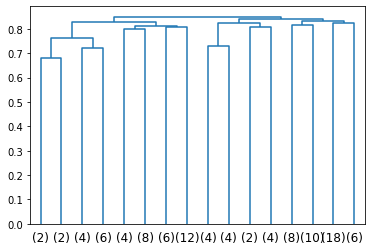

In [24]:
from scipy.cluster.hierarchy import dendrogram

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

from sklearn.cluster import AgglomerativeClustering
model = AgglomerativeClustering(distance_threshold=0.0, n_clusters=None, affinity=sim_affinity, linkage="complete")
model = model.fit(X_train)
plot_dendrogram(model, truncate_mode="level", p=3)

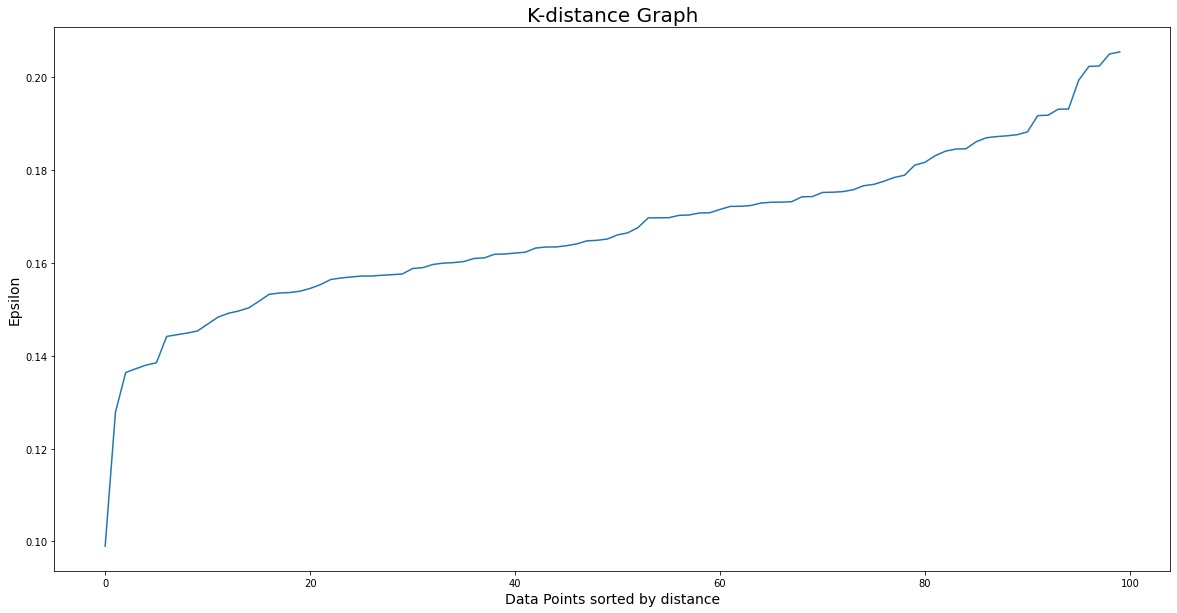

In [25]:
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=5, metric=similarity_score_reader)
nbrs = neigh.fit(X_train)
distances, indices = nbrs.kneighbors(X_train)

# Plotting K-distance Graph
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.figure(figsize=(20,10))
plt.plot(distances)
plt.title('K-distance Graph',fontsize=20)
plt.xlabel('Data Points sorted by distance',fontsize=14)
plt.ylabel('Epsilon',fontsize=14)
plt.show()

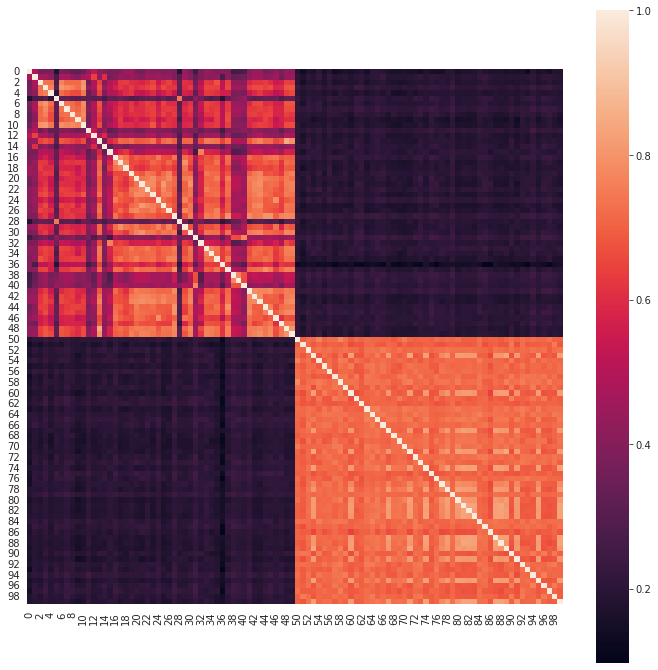

In [26]:
import seaborn as sns
# sns.heatmap(sim_affinity(X_train), figsize=(10, 10))
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(12, 12))
    ax = sns.heatmap(sim_affinity(X_train), square=True)

In [27]:
from sklearn.cluster import KMeans
def get_cluster_kmeans(tfidf_matrix, num_clusters):
    km = KMeans(n_clusters = num_clusters)
    km.fit(tfidf_matrix)
    cluster_list = km.labels_.tolist()
    return cluster_list

In [28]:
clustering = get_cluster_kmeans(sim_affinity(X_train), 2)
unique_elements, counts_elements = np.unique(clustering, return_counts=True)
print("Unique Elements:", unique_elements)
print("\nValue Counts:", list(zip(unique_elements, counts_elements)))

Unique Elements: [0 1]

Value Counts: [(0, 50), (1, 50)]
